# EfficientNet-B0 CNN Training and Evaluation for Mode Recognition on MHD Spectrograms

In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../src/')

import numpy as np
import pandas as pd
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from data.dataloading import SpectrogramDataset, repeat_channels
from models.metrics2 import compute_metrics
from models.training import train
from models.evaluation import plot_spectrogram_slices, plot_spectrograms, plot_spectrogram_with_predictions, evaluate_model
from torch.utils.data._utils.collate import default_collate
from sklearn.model_selection import train_test_split, KFold

from torchsummary import summary
import matplotlib.pyplot as plt

plt.rcdefaults()

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=False),
    transforms.Lambda(repeat_channels),  # repeat grayscale image to 3 channels to match model input size
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

## Loading the dataset

In [3]:
DATA_PATH = "../data/dataset_h5"
FILE_EXT = "h5"
LABEL_PATH = "../data/MHD_labels"
LABEL_FILE_EXT = "csv"
WINDOW_SIZE = 100  # number of .512ms time steps per window
OVERLAP_FACTOR = 0.6  # overlap between consecutive windows



indices = np.arange(94)
# split the dataset into train/validation and test sets
train_val_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)
# split the dataset into train and validation sets
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)
print("Train indices:", list(train_indices))
print("Val indices:", list(val_indices))
print("Test indices:", list(test_indices))

train_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                                   file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                                   overlap=OVERLAP_FACTOR, transform=transform, shot_filter=train_indices)
val_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP_FACTOR, transform=transform, shot_filter=val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=default_collate, num_workers=0)

Train indices: [86, 6, 43, 68, 27, 38, 7, 65, 29, 4, 87, 19, 53, 36, 51, 66, 59, 28, 37, 84, 77, 1, 16, 64, 30, 32, 62, 69, 17, 49, 79, 18, 24, 74, 57, 50, 56, 92, 11, 34, 73, 45, 54, 47, 89, 71, 82, 41, 76, 60, 48, 88, 2, 3, 80, 35, 46, 70, 90, 42, 20, 85, 9, 81, 21, 33, 75]
Val indices: [23, 83, 58, 5, 78, 52, 15, 31, 12, 63, 8, 93, 13, 14, 91, 61, 25]
Test indices: [40, 22, 55, 72, 0, 26, 39, 67, 10, 44]


Processing dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 4347
Shot numbers: [72966, 64401, 70390, 71292, 64770, 70382, 64646, 71264, 64778, 64392, 72967, 64673, 71192, 70380, 71189, 71265, 71225, 64774, 70381, 72964, 72927, 64376, 64666, 71260, 64820, 70355, 71256, 71300, 64668, 71186, 72929, 64670, 64682, 72920, 71223, 71188, 71222, 73022, 64650, 70357, 72919, 70392, 71193, 70394, 73019, 72196, 72961, 70388, 72926, 71226, 71182, 73018, 64378, 64389, 72930, 70359, 70393, 71303, 73020, 70389, 64675, 72965, 64648, 72959, 64677, 70356, 72925]


Processing dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 1029
Shot numbers: [64680, 72963, 71224, 64394, 72928, 71190, 64664, 64834, 64658, 71259, 64647, 73023, 64659, 64662, 73021, 71255, 64684]


In [4]:
# check proportion of positive samples in train set to adjust positive weight in loss function
j = 0
for i in range(len(train_loader.dataset) - 1):
    j += train_loader.dataset[i]['label']
pos_proportion = j / len(train_loader.dataset)
print(f"proportion of positive samples in train set: {pos_proportion.item():.3%}")

proportion of positive samples in train set: 18.127%


## Defining the model

In [5]:
# EfficientNet-B0 -- 4M params
model = timm.create_model('efficientnet_b0', pretrained=True, drop_rate=0.3)

# replace classifier layer for binary classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 640), 
    nn.ReLU(),
    nn.Linear(640, 1),  # output one value
)

if device == "cuda":
    model = model.to('cuda')
else:
    model = model.to('cpu')
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 16, 1

## Training the model

In [6]:
num_epochs = 7

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1/pos_proportion]).to(device))  # binary Cross Entropy Loss with Logits
optimizer = torch.optim.AdamW(model.parameters(), lr=7e-5, weight_decay=1)  # AdamW optimizer with weight decay regularization

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

training on device 'cuda'


Epoch 0:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 0 | Train accuracy: 0.978, f1: 0.940, kappa: 0.926, best threshold: 0.790
     Validation accuracy: 0.942, f1: 0.787, kappa: 0.754, best threshold: 0.930


Epoch 1:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 1 | Train accuracy: 0.995, f1: 0.986, kappa: 0.983, best threshold: 0.850
     Validation accuracy: 0.941, f1: 0.799, kappa: 0.764, best threshold: 0.910


Epoch 2:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 2 | Train accuracy: 0.998, f1: 0.994, kappa: 0.993, best threshold: 0.800
     Validation accuracy: 0.942, f1: 0.796, kappa: 0.762, best threshold: 0.930


Epoch 3:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 3 | Train accuracy: 0.999, f1: 0.997, kappa: 0.997, best threshold: 0.820
     Validation accuracy: 0.941, f1: 0.796, kappa: 0.761, best threshold: 0.940


Epoch 4:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 4 | Train accuracy: 1.000, f1: 0.999, kappa: 0.998, best threshold: 0.520
     Validation accuracy: 0.942, f1: 0.796, kappa: 0.762, best threshold: 0.950


Epoch 5:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 5 | Train accuracy: 1.000, f1: 0.999, kappa: 0.998, best threshold: 0.510
     Validation accuracy: 0.943, f1: 0.800, kappa: 0.767, best threshold: 0.950


Epoch 6:   0%|          | 0/68 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?batch/s]

Epoch 6 | Train accuracy: 1.000, f1: 0.999, kappa: 0.998, best threshold: 0.480
     Validation accuracy: 0.943, f1: 0.800, kappa: 0.767, best threshold: 0.930


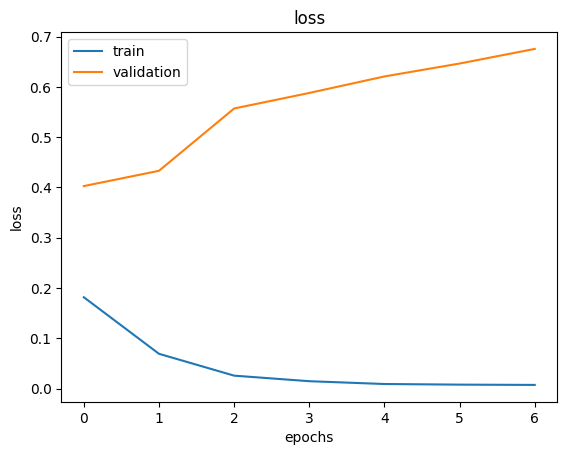

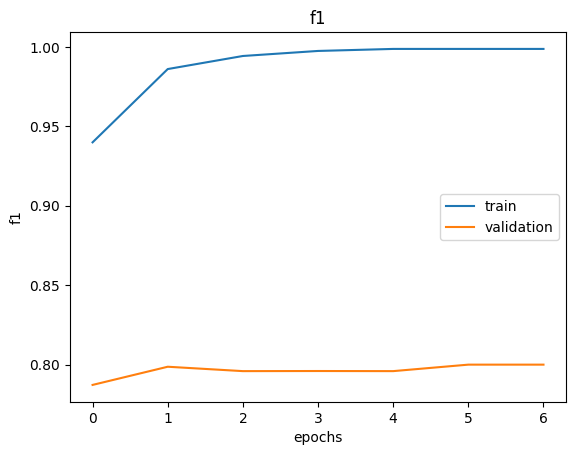

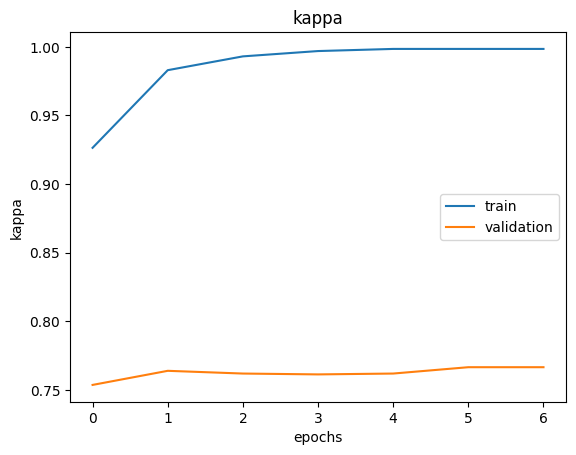

best threshold over validation set: 0.93


(0.9987325728770595,
 0.7999999999999999,
 0.9984515166551905,
 0.7665563104892201,
 0.48,
 0.93)

In [7]:
train(model, train_loader, val_loader, optimizer, scheduler, criterion, device, n_epochs=num_epochs)

## Evaluating the model & visualizing predictions
### Loading test set

In [8]:
WINDOW_SIZE = 100
OVERLAP = OVERLAP_FACTOR
test_dataset = SpectrogramDataset(data_path=DATA_PATH, file_ext=FILE_EXT, data_path_labels=LABEL_PATH,
                             file_ext_labels=LABEL_FILE_EXT, window_size=WINDOW_SIZE,
                             overlap=OVERLAP, transform=transform, shot_filter=test_indices)

test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, collate_fn=default_collate, num_workers=0)

Processing dataset:   0%|          | 0/10 [00:00<?, ?it/s]

Spectrogram slice shape: (800, 100)
Number of slices = 758
Shot numbers: [70387, 64678, 71194, 72198, 64374, 64686, 70383, 71266, 64649, 70391]


### Evaluating the model on the test set

In [11]:
# evaluate model on test set (using mean cross-validation best decision threshold)
THRESHOLD = 0.51
accuracy, f1, kappa = evaluate_model(model, test_loader, device, threshold=THRESHOLD)
print(f"Test set evaluation metrics: Accuracy: {accuracy:.3f}\n"
      f"                                   F1: {f1:.3f}\n"
      f"                        Cohen's Kappa: {kappa:.3f}")

Evaluating:   0%|          | 0/1 [00:00<?, ?batch/s]

Test set evaluation metrics: Accuracy: 0.904
                                   F1: 0.821
                        Cohen's Kappa: 0.756


### Visualizing model performance on random spectrogram samples from the test set

Considering test shots: [71194, 64678, 70391, 70383]
Processing 48 slices for shot number 71194


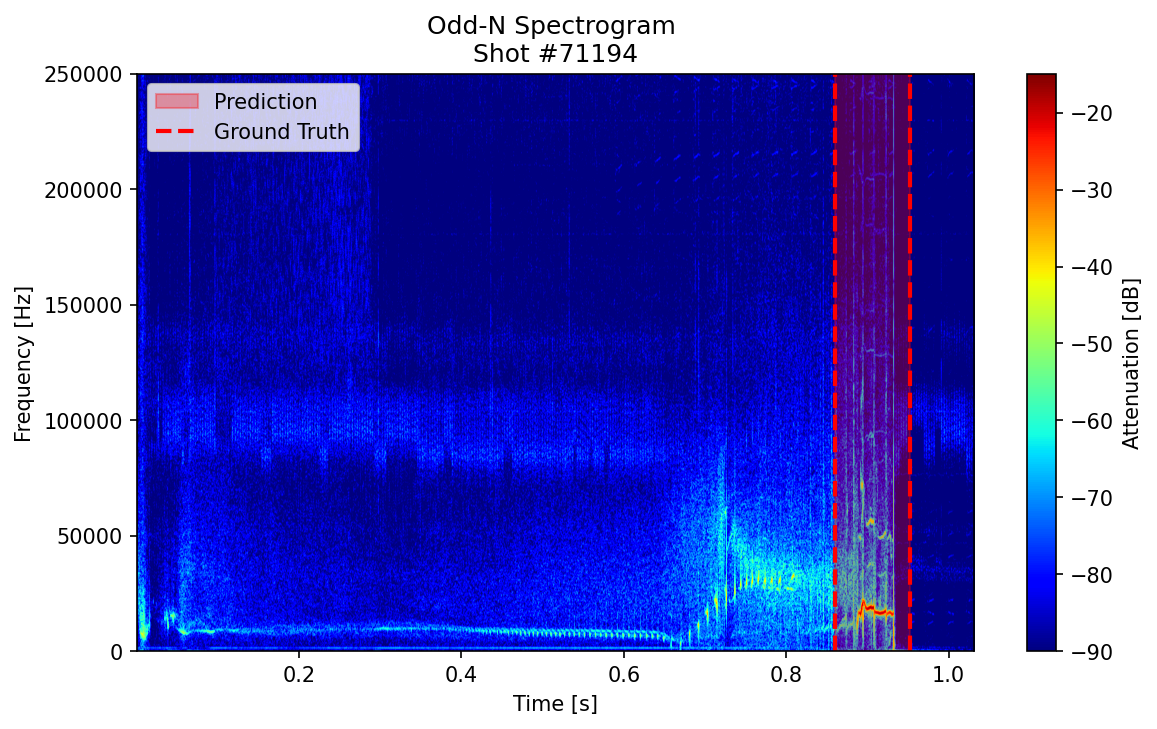

Processing 87 slices for shot number 64678


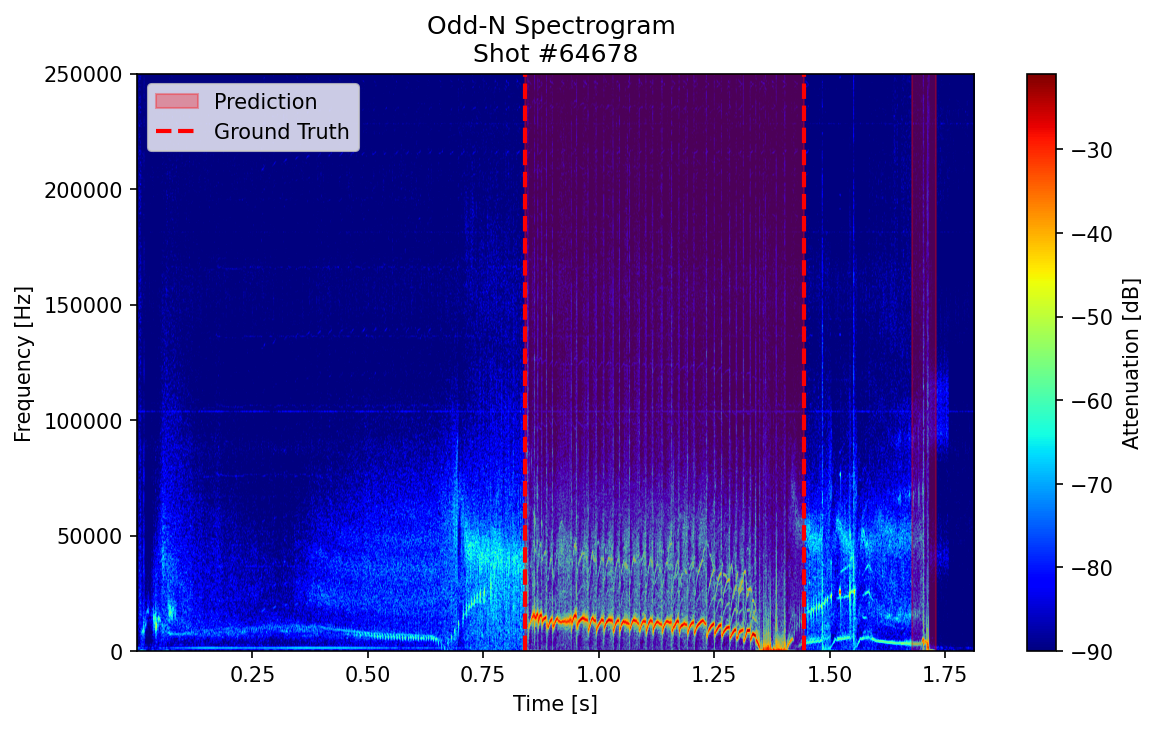

Processing 65 slices for shot number 70391


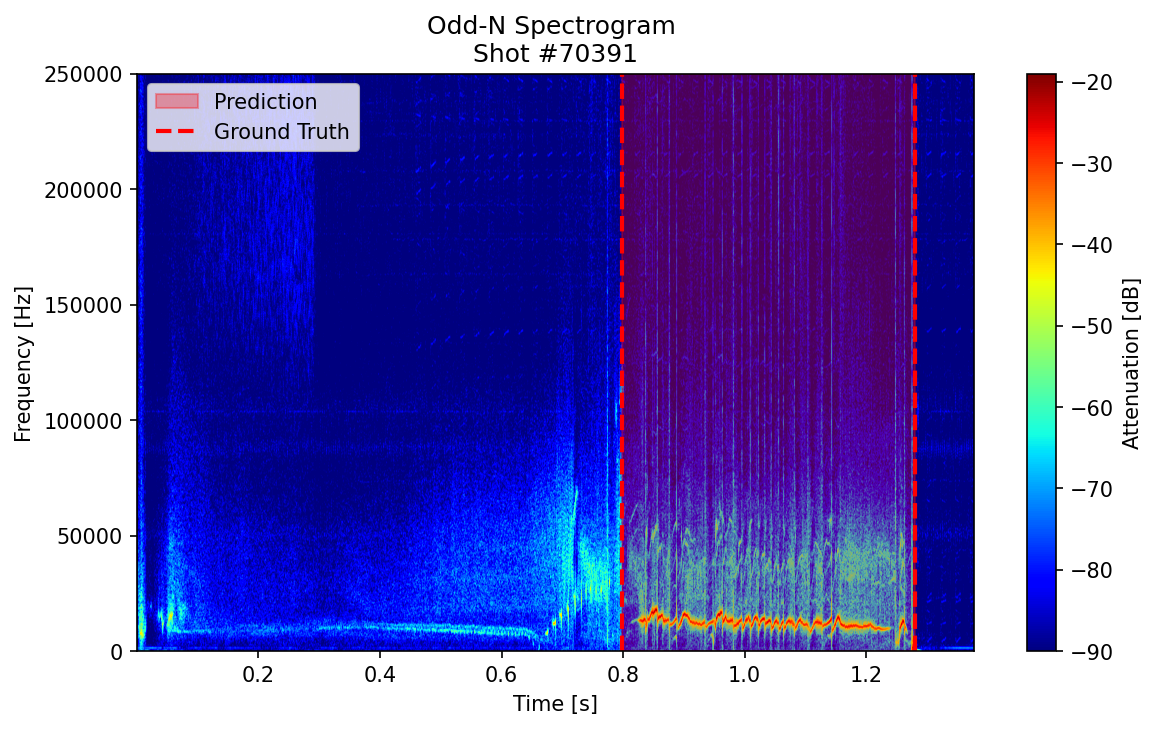

Processing 86 slices for shot number 70383


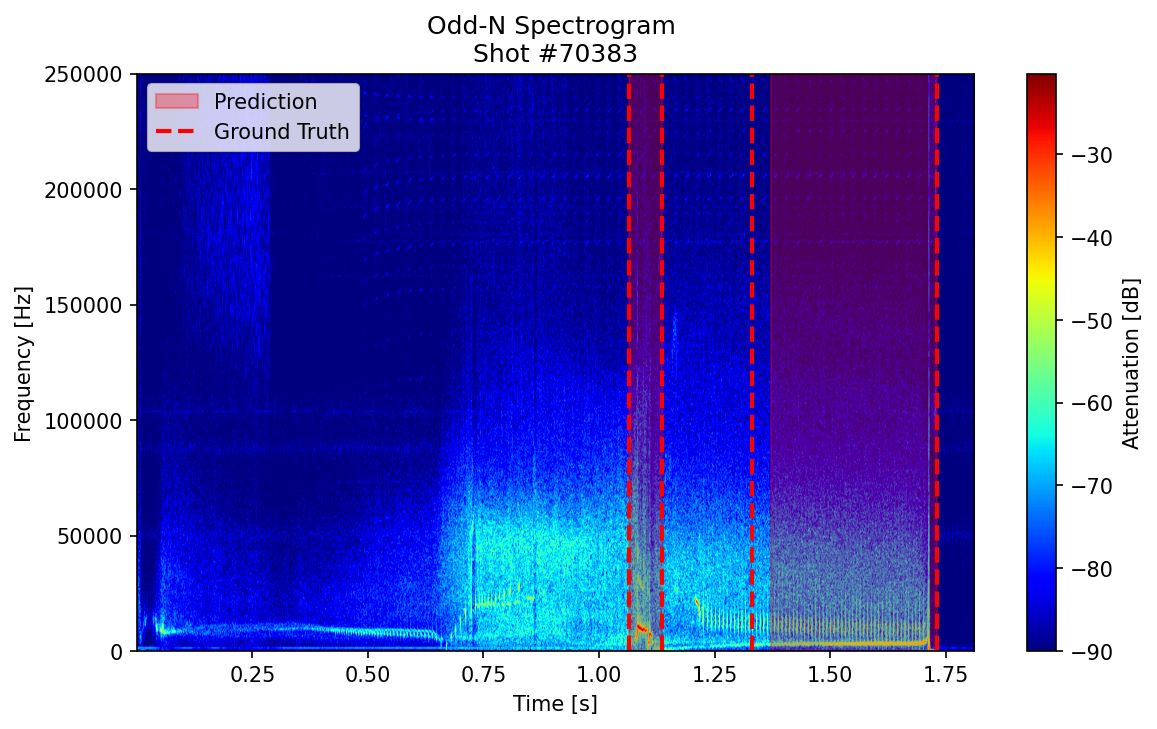

In [10]:
# let's check our predictions on some random shots from the test set
np.random.seed(77)
shotnos = list(np.random.choice(test_loader.dataset.shotnos, size=4, replace=False))
print(f"Considering test shots: {shotnos}")

plot_spectrogram_with_predictions(shotnos, DATA_PATH, FILE_EXT, model, test_loader, device, WINDOW_SIZE, OVERLAP, threshold=THRESHOLD)

### Visualizing pre-processed model input slices

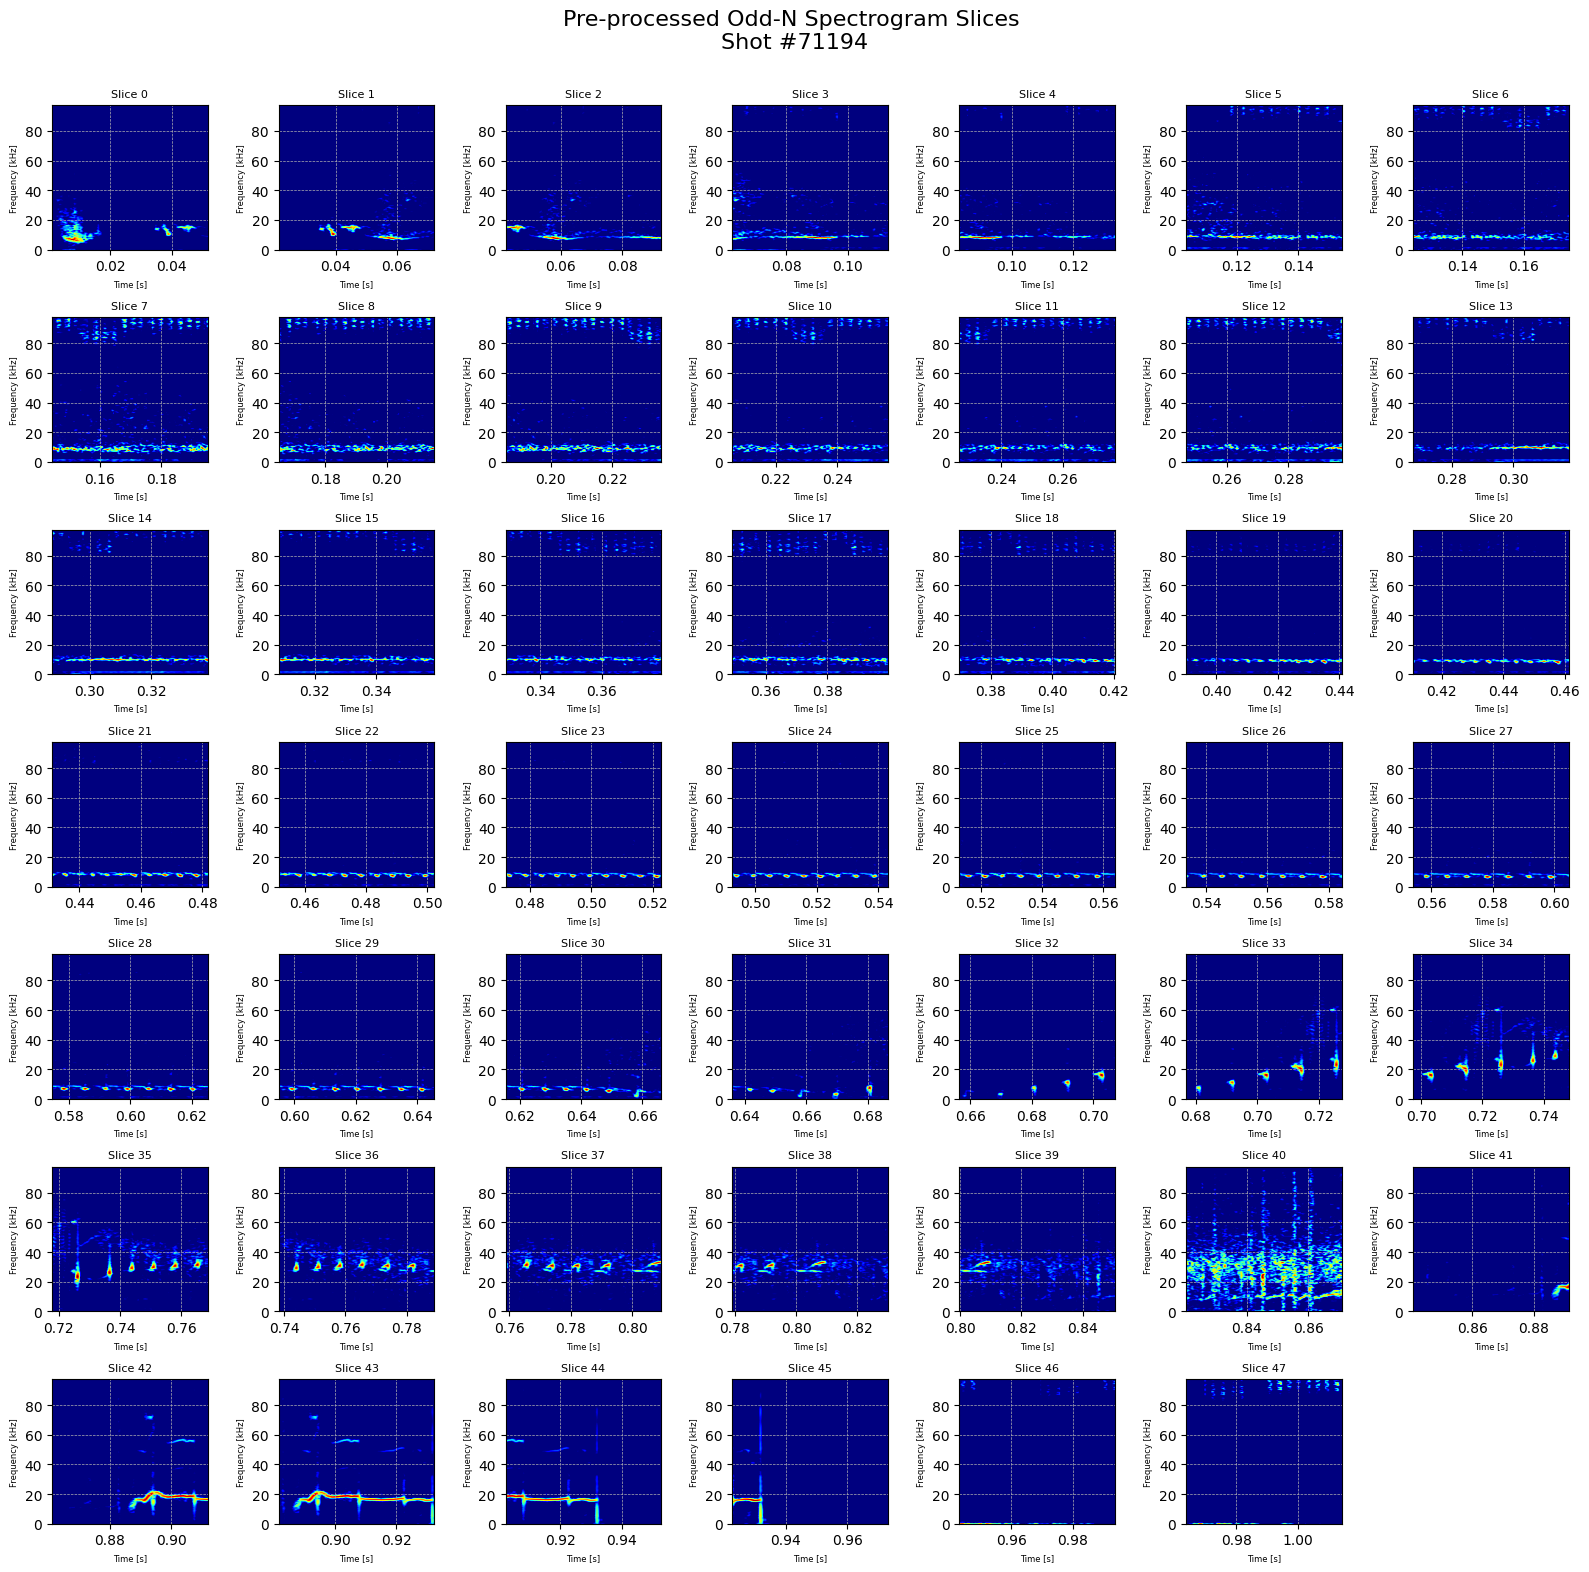

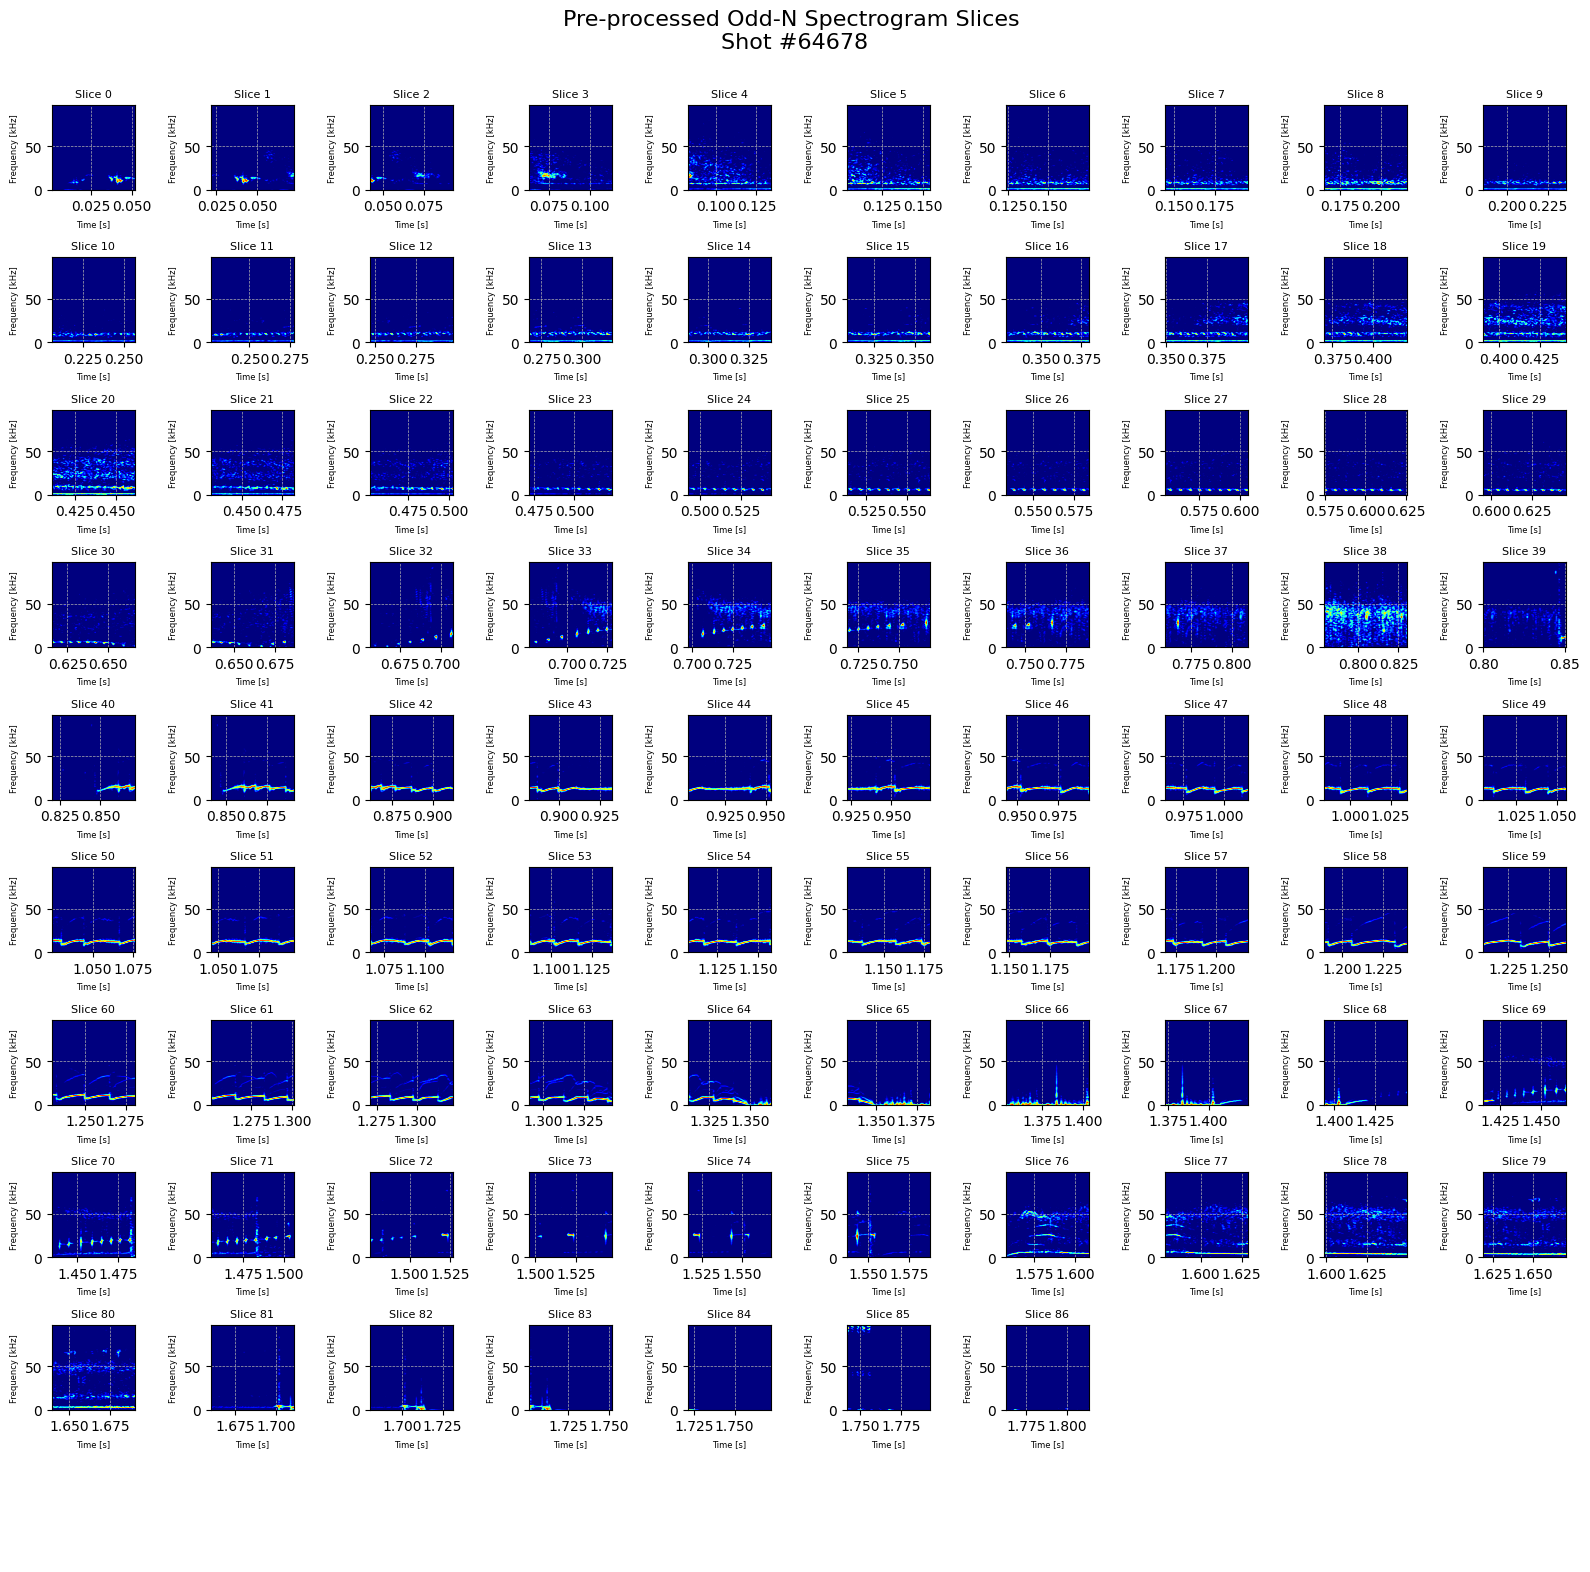

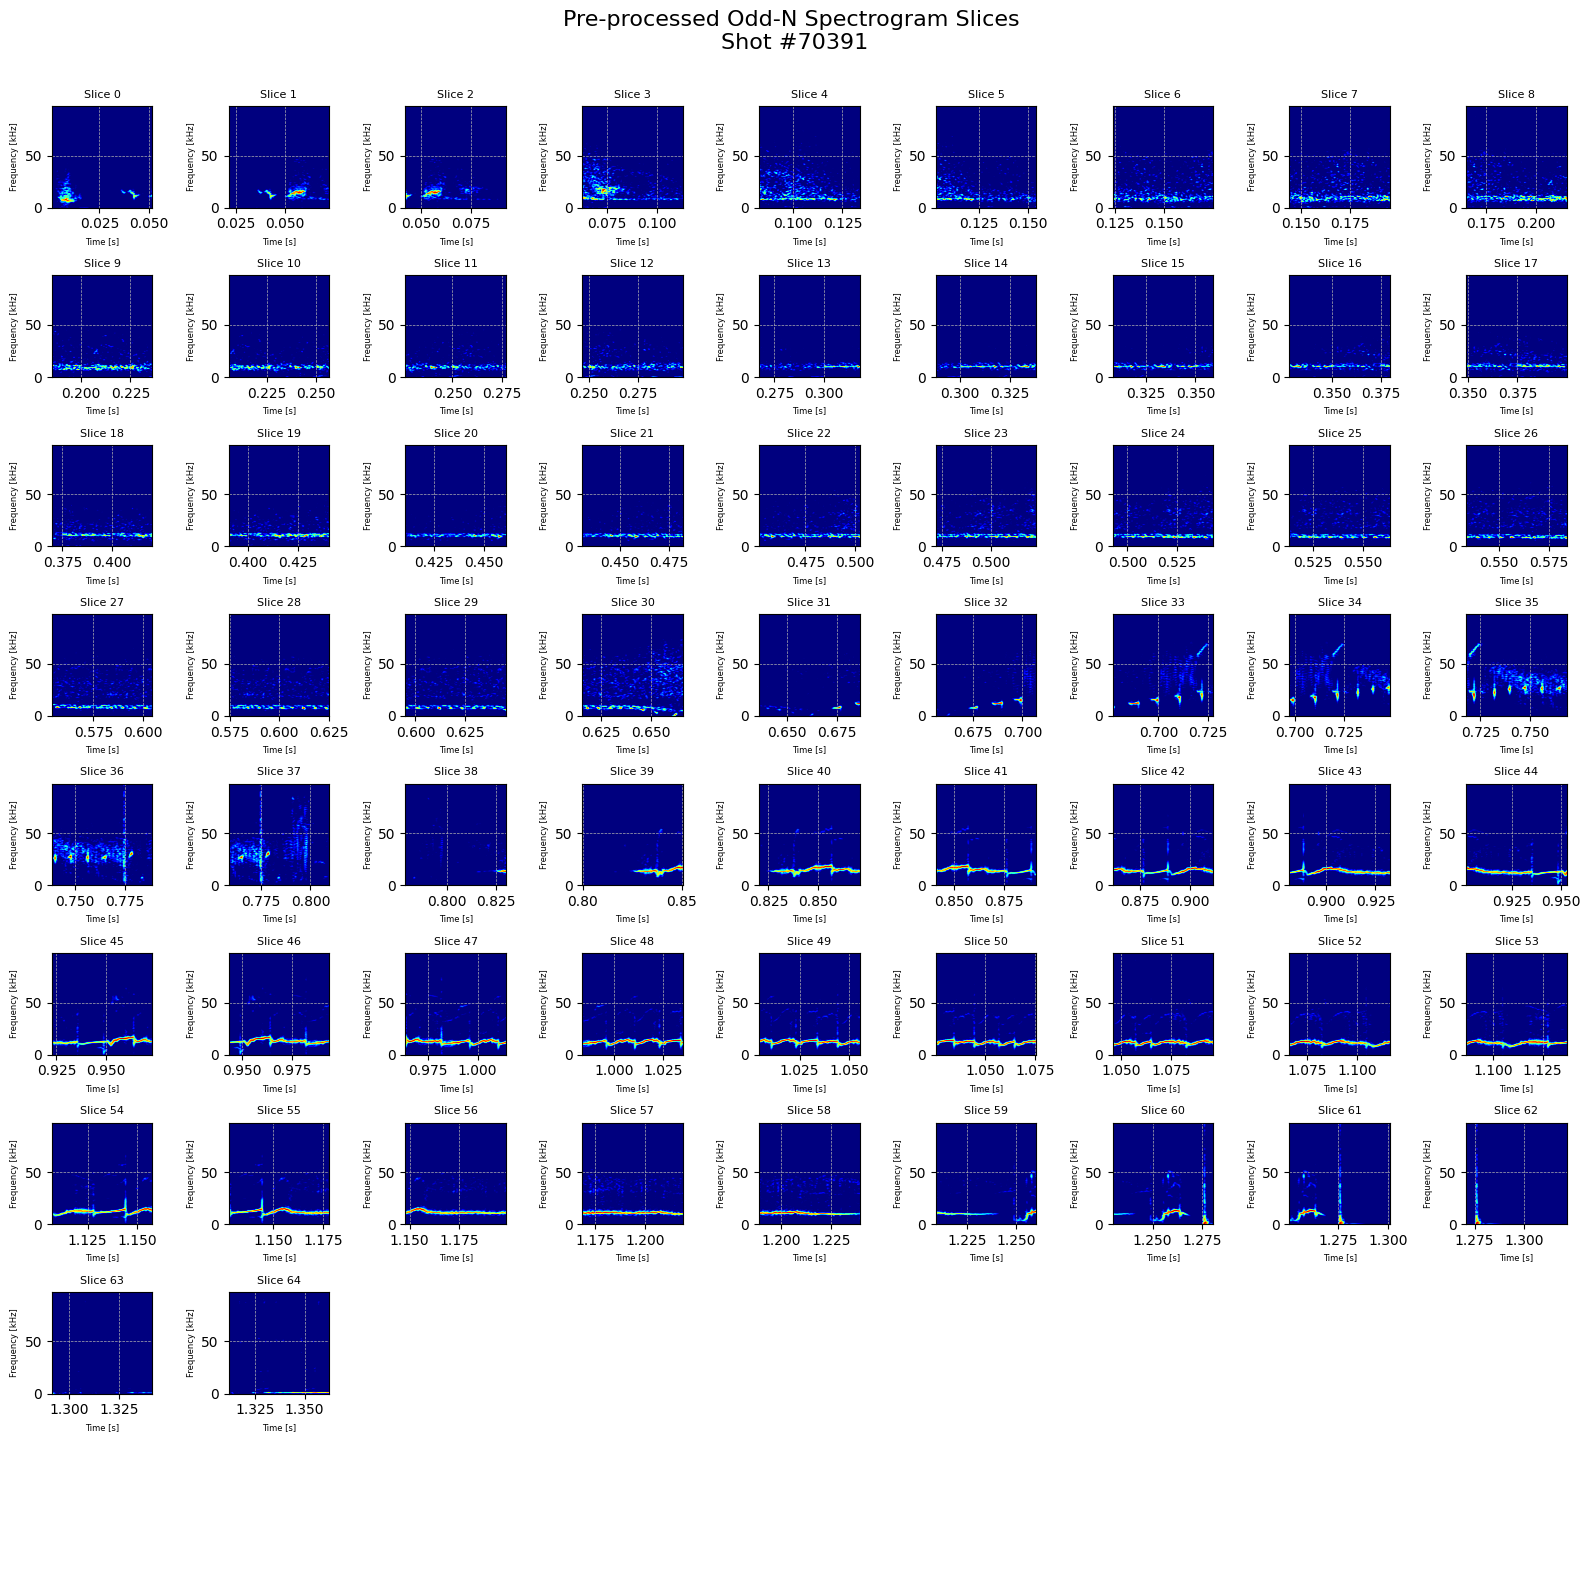

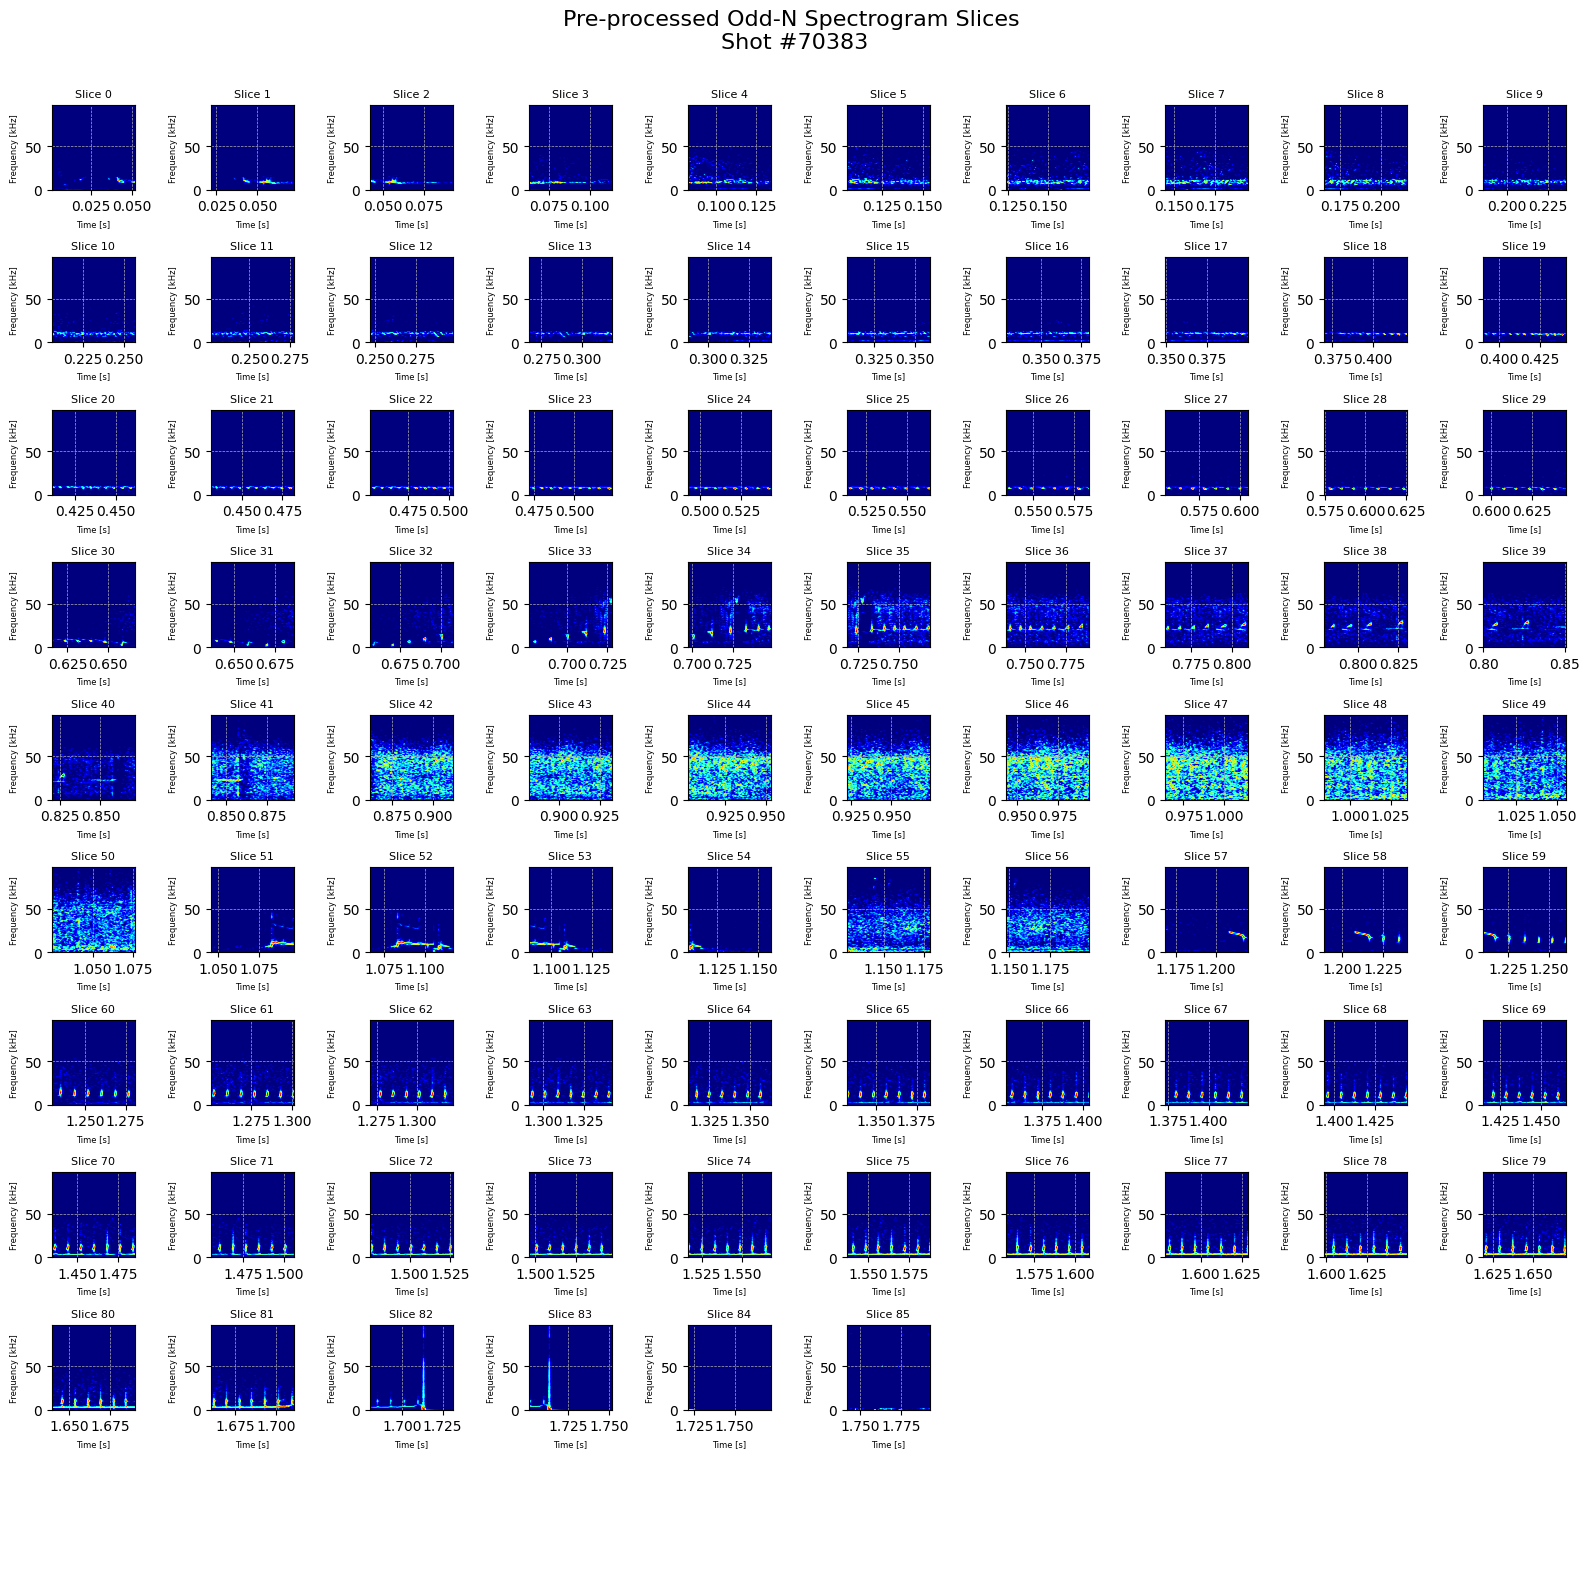

In [11]:
plot_spectrogram_slices(test_loader, shotnos)